In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter

In [7]:
df = pd.read_csv("C:\\Users\\hp\\Documents\\GitHub\\IMD-Data sets\\Data sets\\Churn predection\\churn_prediction.csv")
df.shape

(28382, 21)

In [8]:
df['churn'].value_counts()

0    23122
1     5260
Name: churn, dtype: int64

# Data Preprocessing

In [9]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64

### 1. Missing value Treatment

In [10]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

# Replace with -1 for missing gender
df['gender'] = df['gender'].fillna(-1)

# Replacing with max. occurence values
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')
df['city'] = df['city'].fillna(1020)

### 2. Dummy Variables

In [11]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [12]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,2101,66,1.0,0.0,self_employed,187.0,2,755,1458.71,...,0.20,1458.71,1458.71,0,21-05-2019,0,0,0,1,0
1,2,2348,35,1.0,0.0,self_employed,1020.0,2,3214,5390.37,...,100.56,6496.78,8787.61,0,01-11-2019,0,0,0,1,0
2,4,2194,31,1.0,0.0,salaried,146.0,2,41,3913.16,...,259.23,5006.28,5070.14,0,NaT,0,0,1,0,0
3,5,2329,90,-1.0,0.0,self_employed,1020.0,2,582,2291.91,...,2143.33,2291.91,1669.79,1,06-08-2019,0,0,0,1,0
4,6,1579,42,1.0,2.0,self_employed,1494.0,3,388,927.72,...,1538.06,1157.15,1677.16,1,03-11-2019,0,0,0,1,0


# Train and Test Split

In [13]:
#x = df.drop('Attrition', axis=1)
x = df.drop(['churn','customer_id', 'occupation', 'last_transaction'], axis=1)
y = df['churn']
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size=0.8, stratify = y, random_state=100)

In [14]:
y_train.shape, y_test.shape

((22705,), (5677,))

In [15]:
y_train.value_counts()/len(y_train)

0    0.814666
1    0.185334
Name: churn, dtype: float64

In [16]:
    y_test.value_counts()/len(y_test)

0    0.814691
1    0.185309
Name: churn, dtype: float64

In [17]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

# Applying different Techniques to handle class imbalance

## 1. Over Sampling

   ### 1.1 SMOTE 

In [20]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 18497})


### 1.2 ADASYN

In [27]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 17388})


## 2. Under Sampling

### 2.1 Tomek Links

In [26]:
from imblearn.under_sampling import TomekLinks

counter = Counter(y_train)
print('Before',counter)
# undersampling the train dataset using TomekLinks
toml = TomekLinks()
X_train_toml, y_train_toml = toml.fit_resample(X_train, y_train)

counter = Counter(y_train_toml)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 17142, 1: 4208})


### 2.2 Near Miss

In [28]:
from imblearn.under_sampling import NearMiss

counter = Counter(y_train)
print('Before',counter)
# undersampling the train dataset using Near Miss
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

counter = Counter(y_train_nm)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 4208, 1: 4208})


## 3. Hybrid Techniques

### 3.1 SMOTE + Tomek Links

In [29]:
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18090, 1: 18090})


# Building Models

In [30]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [31]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

## Model-1: Logistic Regression

### 1. Original Unsampled Data 

In [32]:
log_model=LogisticRegression()

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train, y_train)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0)

In [33]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'actual')

Confusion Matrix
[[4596   29]
 [ 966   86]] 

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4625
           1       0.75      0.08      0.15      1052

    accuracy                           0.82      5677
   macro avg       0.79      0.54      0.52      5677
weighted avg       0.81      0.82      0.76      5677
 

AUC-ROC
0.7734372623574144


### 2. SMOTE Resampling

In [34]:
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0, class_weight='balanced')

In [35]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote')

Confusion Matrix
[[3760  865]
 [ 335  717]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4625
           1       0.45      0.68      0.54      1052

    accuracy                           0.79      5677
   macro avg       0.69      0.75      0.70      5677
weighted avg       0.83      0.79      0.80      5677
 

AUC-ROC
0.7787754598705169


### 3. ADASYN Resampling

In [36]:
clf_LR.fit(X_train_ada, y_train_ada)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0)

In [37]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'adasyn')

Confusion Matrix
[[3926  699]
 [ 364  688]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4625
           1       0.50      0.65      0.56      1052

    accuracy                           0.81      5677
   macro avg       0.71      0.75      0.72      5677
weighted avg       0.84      0.81      0.82      5677
 

AUC-ROC
0.7792021374987154


### 4. Tomek Links Resampling

In [38]:
clf_LR.fit(X_train_toml, y_train_toml)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0)

In [39]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'tomek links')

Confusion Matrix
[[4592   33]
 [ 952  100]] 

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4625
           1       0.75      0.10      0.17      1052

    accuracy                           0.83      5677
   macro avg       0.79      0.54      0.54      5677
weighted avg       0.81      0.83      0.77      5677
 

AUC-ROC
0.7725837015722947


### 5. Near Miss Resampling

In [40]:
clf_LR.fit(X_train_nm, y_train_nm)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0, class_weight='balanced')

In [41]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'near miss')

Confusion Matrix
[[2307 2318]
 [ 290  762]] 

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      4625
           1       0.25      0.72      0.37      1052

    accuracy                           0.54      5677
   macro avg       0.57      0.61      0.50      5677
weighted avg       0.77      0.54      0.59      5677
 

AUC-ROC
0.6607798787380537


### 6. SMOTE + Tomek Resampling

In [42]:
clf_LR.fit(X_train_smtom, y_train_smtom)
clf_LR.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0)

In [43]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+tomek')

Confusion Matrix
[[3735  890]
 [ 335  717]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4625
           1       0.45      0.68      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7783409721508581


## Model-2: Decision Tree

In [44]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

### 1. Original Unsampled Data

In [45]:
tree_model = DecisionTreeClassifier()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5)

In [46]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[4420  205]
 [ 618  434]] 

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      4625
           1       0.68      0.41      0.51      1052

    accuracy                           0.86      5677
   macro avg       0.78      0.68      0.71      5677
weighted avg       0.84      0.86      0.84      5677
 

AUC-ROC
0.7927214058164628


### 2. SMOTE Resampling

In [47]:
clf_DT.fit(X_train_sm, y_train_sm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


DecisionTreeClassifier(max_depth=9, min_samples_split=100)

In [48]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote')

Confusion Matrix
[[3678  947]
 [ 391  661]] 

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4625
           1       0.41      0.63      0.50      1052

    accuracy                           0.76      5677
   macro avg       0.66      0.71      0.67      5677
weighted avg       0.81      0.76      0.78      5677
 

AUC-ROC
0.7795587298324942


### 3. ADASYN Resampling

In [49]:
clf_DT.fit(X_train_ada, y_train_ada)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=100)

In [50]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'adasyn')

Confusion Matrix
[[3701  924]
 [ 323  729]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      4625
           1       0.44      0.69      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.75      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7944864864864866


### 4. Tomek Links Resampling

In [51]:
clf_DT.fit(X_train_toml, y_train_toml)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=100)

In [52]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'tomek links')

Confusion Matrix
[[4343  282]
 [ 552  500]] 

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4625
           1       0.64      0.48      0.55      1052

    accuracy                           0.85      5677
   macro avg       0.76      0.71      0.73      5677
weighted avg       0.84      0.85      0.84      5677
 

AUC-ROC
0.8071031754187648


### 5. Near Miss Resampling

In [53]:
clf_DT.fit(X_train_nm, y_train_nm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


DecisionTreeClassifier(max_depth=13, min_samples_split=100)

In [54]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'near miss')

Confusion Matrix
[[2466 2159]
 [ 219  833]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.53      0.67      4625
           1       0.28      0.79      0.41      1052

    accuracy                           0.58      5677
   macro avg       0.60      0.66      0.54      5677
weighted avg       0.80      0.58      0.63      5677
 

AUC-ROC
0.7114205117665194


### 6. SMOTE + Tomek Resampling

In [55]:
clf_DT.fit(X_train_smtom, y_train_smtom)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=20)

In [56]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+tomek')

Confusion Matrix
[[3544 1081]
 [ 344  708]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      4625
           1       0.40      0.67      0.50      1052

    accuracy                           0.75      5677
   macro avg       0.65      0.72      0.67      5677
weighted avg       0.82      0.75      0.77      5677
 

AUC-ROC
0.783915733223718


# Comparitive Analysis

In [57]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

In [58]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.747826,0.081749,0.147386,0.773437
1,Logistic Regression,smote,0.453224,0.681559,0.544419,0.778775
2,Logistic Regression,adasyn,0.496035,0.653992,0.564166,0.779202
3,Logistic Regression,tomek links,0.751880,0.095057,0.168776,0.772584
4,Logistic Regression,near miss,0.247403,0.724335,0.368829,0.660780
5,Logistic Regression,smote+tomek,0.446173,0.681559,0.539300,0.778341
6,Decision Tree,actual,0.679186,0.412548,0.513306,0.792721
7,Decision Tree,smote,0.411070,0.628327,0.496992,0.779559
8,Decision Tree,adasyn,0.441016,0.692966,0.539002,0.794486
9,Decision Tree,tomek links,0.639386,0.475285,0.545256,0.807103


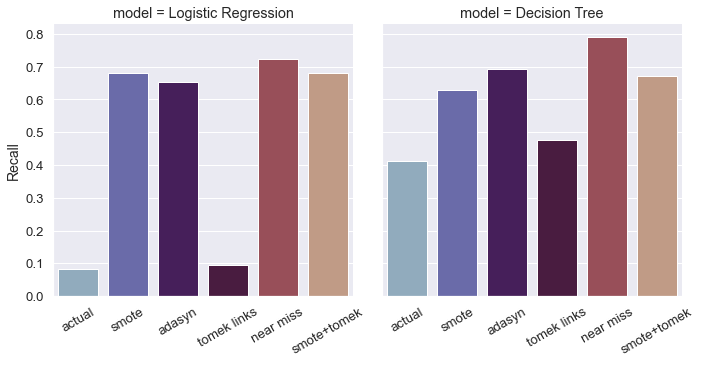

In [59]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "smote", "adasyn", "tomek links", "near miss", "smote+tomek"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)

# Visualizing Resampling

In [60]:
from sklearn.datasets import make_classification

In [61]:
X, Y = make_classification(n_samples=20000, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=2,
                            n_clusters_per_class=1,
                            weights=[0.95, 0.05],
                            class_sep=0.8, random_state=100)

In [62]:
X1, X2 = list(), list()
for i, j in enumerate(X):
    X1.append(j[0])
    X2.append(j[1])

In [63]:
df = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y})

In [64]:
pal = sns.color_palette('tab10')
print(pal.as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


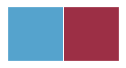

In [65]:
#sns.set_palette('icefire')
sns.set_palette(['#55a3cd', '#9c2f45'])
sns.palplot(sns.color_palette())

### Imblanced Data

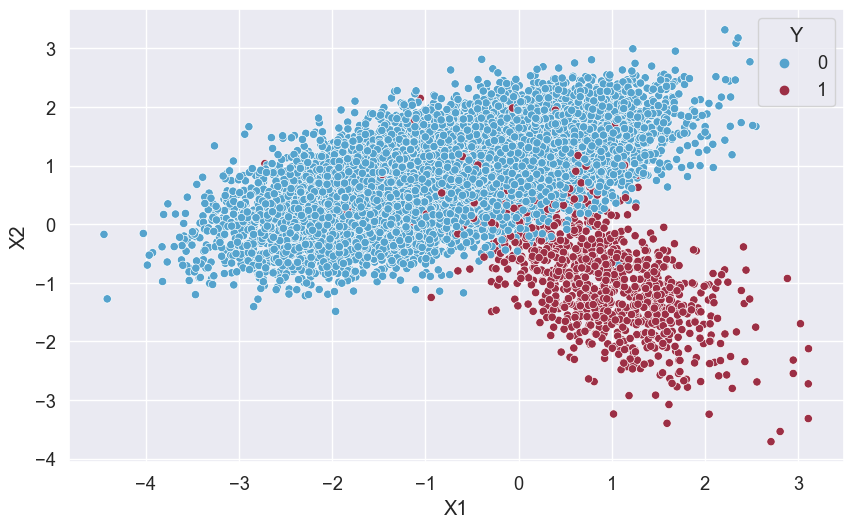

In [66]:
plt.figure(figsize=(10,6),dpi=100)

sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df)
plt.show()

In [67]:
df['Y'].value_counts()

0    18909
1     1091
Name: Y, dtype: int64

In [68]:
x = df.drop('Y', axis=1)
y = df['Y']

## Resampling Techniques: SMOTE, ADASYN, Tomek Links, Near Miss, SMOTE + Tomek Links

In [69]:
from imblearn.over_sampling import SMOTE

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train1, y_train1 = smt.fit_resample(x, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 18909, 1: 1091})
After Counter({0: 18909, 1: 18909})


In [70]:
df_sm = X_train1.copy()
df_sm['Y'] = y_train1

In [71]:
from imblearn.over_sampling import ADASYN

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
ada = ADASYN()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train1, y_train1 = ada.fit_resample(x, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 18909, 1: 1091})
After Counter({1: 18966, 0: 18909})


In [72]:
df_ada = X_train1.copy()
df_ada['Y'] = y_train1

In [73]:
from imblearn.under_sampling import TomekLinks

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
toml = TomekLinks()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train1, y_train1 = toml.fit_resample(x, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 18909, 1: 1091})
After Counter({0: 18749, 1: 1091})


In [74]:
df_toml = X_train1.copy()
df_toml['Y'] = y_train1

In [75]:
from imblearn.under_sampling import NearMiss

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
nm = NearMiss()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train1, y_train1 = nm.fit_resample(x, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 18909, 1: 1091})
After Counter({0: 1091, 1: 1091})


In [76]:
df_nm = X_train1.copy()
df_nm['Y'] = y_train1

In [77]:
from imblearn.combine import SMOTETomek

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train1, y_train1 = smtom.fit_resample(x, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 18909, 1: 1091})
After Counter({0: 18098, 1: 18098})


In [78]:
df_smtom = X_train1.copy()
df_smtom['Y'] = y_train1

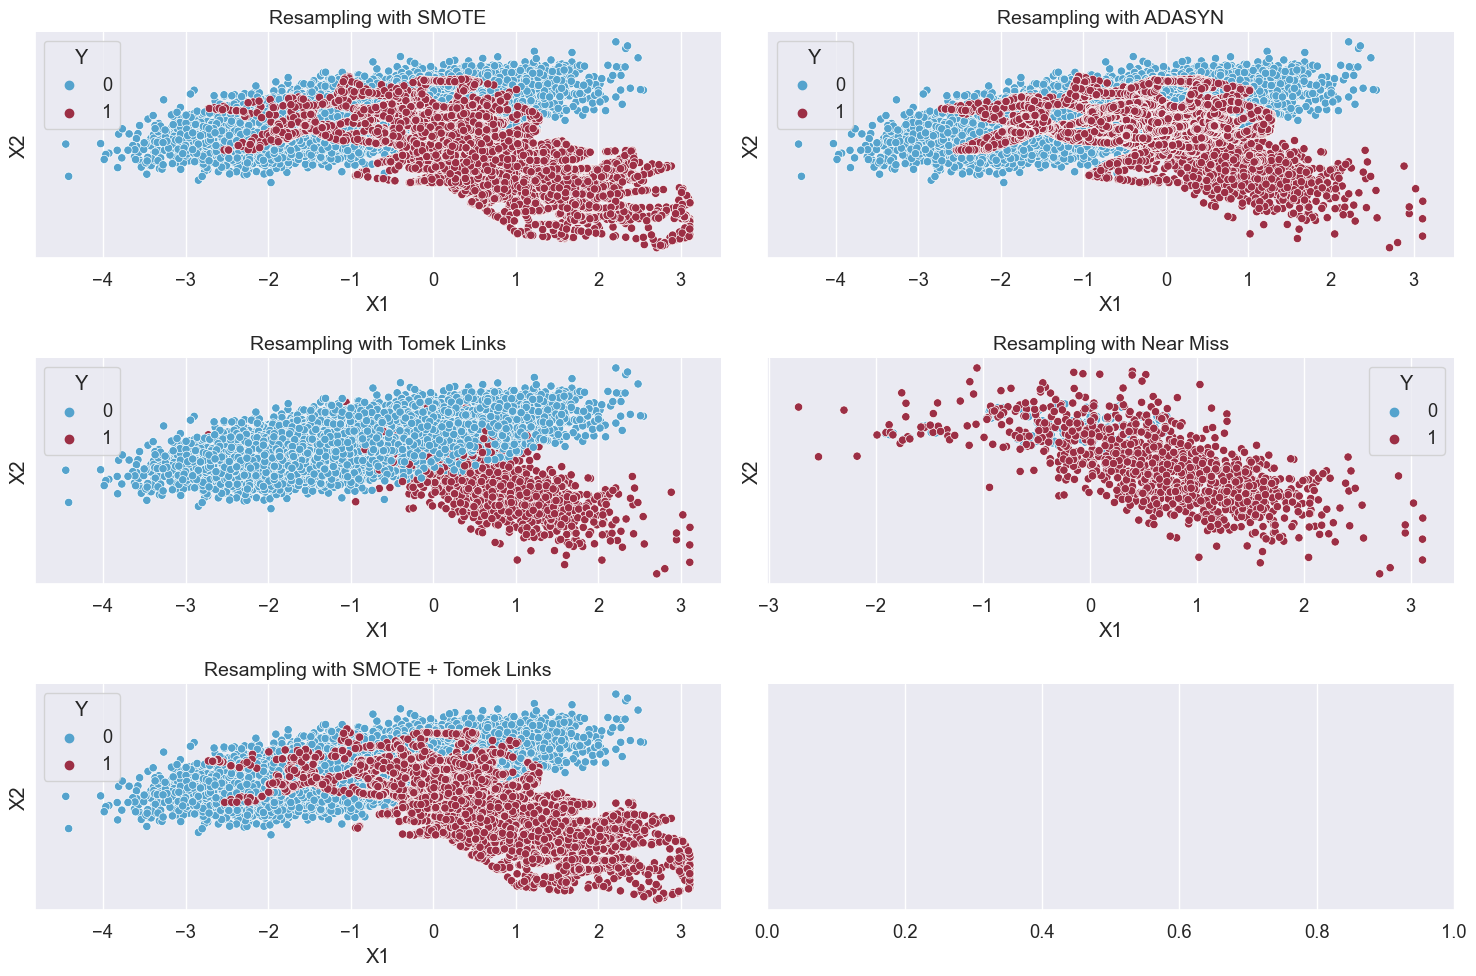

In [81]:
f, axes = plt.subplots(3,2,figsize=(15, 10), dpi=100)
sns.despine()
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_sm, ax=axes[0,0])
axes[0,0].set_title('Resampling with SMOTE', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_ada, ax=axes[0,1])
axes[0,1].set_title('Resampling with ADASYN', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_toml, ax=axes[1,0])
axes[1,0].set_title('Resampling with Tomek Links', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_nm, ax=axes[1,1])
axes[1,1].set_title('Resampling with Near Miss', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_smtom, ax=axes[2,0])
axes[2,0].set_title('Resampling with SMOTE + Tomek Links', fontsize=14)
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()